# DEEPMIND ALPHAZERO CHESS

## TODO
- Encode actions
- Create training data for MDN-LSTM
- Pretrain MDN-LSTM
- Create controller (MDN-LSTM should be trainable)
- Link Controller - Monte Carlo Tree Search 
- Create Self play class
- Create Arena class

DEEP MIND OPEN ACCESS PAPER 

https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd

DISTRIBUTED IMPLEMENTATION

https://github.com/mokemokechicken/reversi-alpha-zero/blob/master/src/reversi_zero/lib/ggf.py

CHESS MOVES

https://www.ichess.net/blog/chess-pieces-moves/

BOARD REPRESENTATIONS

https://medium.com/datadriveninvestor/reconstructing-chess-positions-f195fd5944e

ALPHA ZERO EXPLANATION

https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

TRANSFORMER NETWORK IMPLEMENTATION

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [1]:
import chess, gym, pickle, random, torch, cv2
import numpy as np
import pandas as pd
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import torch.optim as optim
# plt.style.use('ggplot')
from scipy.ndimage.interpolation import shift

from utilities import *
# import constants 
from constants import *
from models.vae import CNN_VAE, train_vae
from models.mdn import MDN_RNN, loss_function, clip_grad_norm_

# REFERENCES
# Tensorflow implementation for Chess
# https://github.com/saurabhk7/chess-alpha-zero

# Pytorch implementation for Connect4
# https://github.com/plkmo/AlphaZero_Connect4/tree/master/src

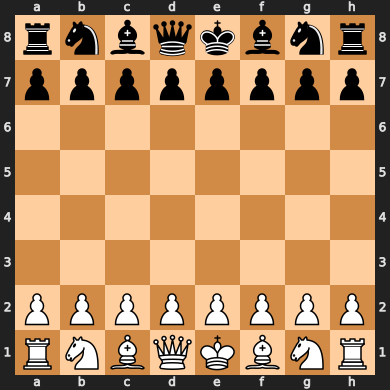

In [2]:
class Chess_Environment(gym.Env):
    """Chess Environment"""
    def __init__(self):
        self.board = chess.Board()
        self.white_pieces = ['P', 'N', 'B', 'R', 'Q', 'K']
        self.black_pieces = [piece.lower() for piece in self.white_pieces]
        self.x_coords, self.y_coords = np.meshgrid(list(range(0, 8)), list(range(0, 8)))
        self.x_coords = self.x_coords / 7
        self.y_coords = self.y_coords / 7
        self.state_size = self.observe()[0].shape
#         self.action_size = 1968
        self.init_action_decoder()
        self.whites_turn = True

    def reset(self):
        """Resets the environment"""
        self.board = chess.Board()
        
    def terminal_test(self):
        """Checks if the game is over"""
        return self.board.is_game_over()
    
    def result(self):
        """Gives the end game result"""
        if not self.terminal_test():
            raise Exception('Game is not finished!')
        
        result = self.board.result()
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        return 0
        
    def legal_actions(self):
        """Provides a list of legal actions in current state"""
        return [str(legal_action) for legal_action in list(self.board.legal_moves)]
    
    def encode(self):
        """Encodes game state into a string"""
        board_ = self.board.piece_map()
            
        encoded = {
            'board' : board_,
            'turn' : self.board.turn
        }
        
        return pickle.dumps(encoded)
    
    def decode(self, encoded):
        """Decodes string into game state and sets board and turn"""
        decoded = pickle.loads(encoded)
        self.board.set_piece_map(decoded['board'])
        if decoded['turn'] == 0:
            self.board = self.board.mirror()
        self.board.turn = decoded['turn']

    def observe(self):
        """Create observation from the game state"""

        board_ = copy(self.board)
            
        board_ = np.ndarray.flatten(np.array(board_.__str__().split())).reshape(8, 8)
        
        black_pawns = np.isin(copy(board_), ['p']).astype(int)
        black_knights = np.isin(copy(board_), ['n']).astype(int)
        black_rooks = np.isin(copy(board_), ['r']).astype(int)
        black_bishops = np.isin(copy(board_), ['b']).astype(int)
        black_queen = np.isin(copy(board_), ['q']).astype(int)
        black_king = np.isin(copy(board_), ['k']).astype(int)
         
        white_pawns = np.isin(copy(board_), ['P']).astype(int)
        white_knights = np.isin(copy(board_), ['N']).astype(int)
        white_rooks = np.isin(copy(board_), ['R']).astype(int)
        white_bishops = np.isin(copy(board_), ['B']).astype(int)
        white_queen = np.isin(copy(board_), ['Q']).astype(int)
        white_king = np.isin(copy(board_), ['K']).astype(int)
        
        state = np.array([
            white_pawns,
            white_knights,
            white_rooks,
            white_bishops,
            white_queen,
            white_king,
            black_pawns,
            black_knights,
            black_rooks,
            black_bishops,
            black_queen,
            black_king
        ])
        
        return state, self.legal_actions()
    
    def step(self, action):
        """Perform a step in the environment"""
#         action = self.select_action(actions)
        self.board.push_uci(action)
        self.board = self.board.mirror()
        if self.whites_turn:
            self.whites_turn = False
        else:
            self.whites_turn = True
        return self.observe()
    
    def move_board(self, move):
        """Moves the board positions as per the move"""

        char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

        int_to_char = {v: k for k, v in char_to_int.items()}

        encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(BOARD)]

        new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(BOARD)]
        moves = []
        for pos, new_pos in zip(np.ndarray.flatten(BOARD), new_board):
            try:
                if new_pos[1] > 8:
                    raise Exception()
                if move[2] is None:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
                else:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
                if '-' in move_:
                    raise Exception()
            
                if '0' in move_:
                    raise Exception()
                
            except Exception:
                move_ = 'XXXX'
            moves.append(move_)   
        return np.array(moves).reshape(8, 8)
    
    def init_action_decoder(self):
        """Initialize the decoder to decode the actions"""
        decoder = []
        for key in MOVES.keys():
            decoder_ = self.move_board(MOVES[key])
            decoder.append(decoder_)
#             print(f'Move {key}\n', new_board, '\n')
    
        self.decoder = np.array(decoder)
        self.action_size = self.decoder.shape
        
    def select_action(self, logits):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in self.legal_actions()}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action


env = Chess_Environment()
env.board

In [3]:
class Agent:
    
    def __init__(self, decoder, action_size):
        self.action_size = action_size
        self.decoder = decoder
        
        self.char_to_int = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8} 
        self.char_to_int_promo = {'r': 1, 'b': 2, 'q': 3, 'k': 4, 'n': 5, '': 6} 
        
        moves_df = pd.DataFrame(list(zip(self.char_to_int.values(), self.char_to_int.keys())), columns = ['Ids', 'Labels'])
        promo_df = pd.DataFrame(list(zip(self.char_to_int_promo.values(), self.char_to_int_promo.keys())), columns = ['Ids', 'Labels'])
        self.move_actions_ohe = pd.get_dummies(moves_df['Ids'])
        self.promo_actions_ohe = pd.get_dummies(promo_df['Ids'])
    
    def select_action(self, logits, legal_actions):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action
    
    def one_hot_encode_action(self, action):
        """One hot encodes the action"""
        if len(action) == 4:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[''] - 1].values
            ]
        else:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[action[4]] - 1].values
            ]
        ohe_action = np.concatenate(encoded_action)
        return ohe_action
    
    
agent = Agent(env.decoder, env.action_size)
random_action = np.random.rand(env.action_size[0], env.action_size[1], env.action_size[2])

#### Encode State

In [4]:
# state, legal_actions = env.observe()

# state_planes = [
#     'White Pawns',
#     'White Knights',
#     'White Rooks',
#     'White Bishops',
#     'White Queen',
#     'White King',
#     'Black Pawns',
#     'Black Knights',
#     'Black Rooks',
#     'Black Bishops',
#     'Black Queen',
#     'Black King'
# ]

# for inx, state_ in enumerate(state):
#     fig = plt.figure()
#     fig.suptitle(state_planes[inx], fontsize = 20)
#     xticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
#     yticks = list(range(1, 9))
#     yticks.reverse()
#     plt.xticks(list(range(0, 8)), xticks)
#     plt.yticks(list(range(0, 8)), yticks)
#     plt.imshow(state_)


#### Encode Actions

In [5]:
# queen_directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
# queen_distance = list(range(1, 8))
# queen_moves = [f'{direction}{distance}' for direction in queen_directions for distance in queen_distance]

# knight_moves = ['2N1E', '1N2E', '1S2E', '2S1E', '2S1W', '1S2W', '1N2W', '2N1W']
# underpromotion_moves = ['DOUBLEM', 'NECUT', 'NWCUT']
# moves = queen_moves + knight_moves + underpromotion_moves

# print(f'{len(queen_moves)} QUEEN MOVES {queen_moves[: 15]}\n{len(knight_moves)} KNIGHT MOVES {knight_moves}\n{len(underpromotion_moves)} UNDERPROMOTION MOVES {underpromotion_moves}')
# print(f'\nTOTAL MOVES {len(moves)}')
# print(moves)

#### Encode Actions

In [6]:
# def move_board(move):
#     """Moves the board positions as per the move"""
#     print(move)
#     board = np.array([
#         ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8'],
#         ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7'],
#         ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6'],
#         ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5'],
#         ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4'],
#         ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3'],
#         ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'],
#         ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1']
#     ])

#     char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

#     int_to_char = {v: k for k, v in char_to_int.items()}

#     encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(board)]

#     new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(board)]
 
#     moves = []
#     for pos, new_pos in zip(np.ndarray.flatten(board), new_board):
#         try:
# #             print(pos, new_pos)
#             if new_pos[1] > 8:
#                 raise Exception()
            
#             if move[2] is None:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
#             else:
#                 move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
#             if '-' in move_:
#                 raise Exception()
            
#             if '0' in move_:
#                 raise Exception()
                
#         except Exception:
#             move_ = 'XXXX'
#         moves.append(move_)
#     return np.array(moves).reshape(8, 8)

# moves = {
#     # Queen Moves
#     'Q N1': (0, 1, None),
#     'Q N2': (0, 2, None),
#     'Q N3': (0, 3, None),
#     'Q N4': (0, 4, None),
#     'Q N5': (0, 5, None),
#     'Q N6': (0, 6, None),
#     'Q N7': (0, 7, None),
#     'Q NE1': (1, 1, None),
#     'Q NE2': (2, 2, None),
#     'Q NE3': (3, 3, None),
#     'Q NE4': (4, 4, None),
#     'Q NE5': (5, 5, None),
#     'Q NE6': (6, 6, None),
#     'Q NE7': (7, 7, None),
#     'Q E1': (1, 0, None),
#     'Q E2': (2, 0, None),
#     'Q E3': (3, 0, None),
#     'Q E4': (4, 0, None),
#     'Q E5': (5, 0, None),
#     'Q E6': (6, 0, None),
#     'Q E7': (7, 0, None),
#     'Q SE1': (1, -1, None),
#     'Q SE2': (2, -2, None),
#     'Q SE3': (3, -3, None),
#     'Q SE4': (4, -4, None),
#     'Q SE5': (5, -5, None),
#     'Q SE6': (6, -6, None),
#     'Q SE7': (7, -7, None),
#     'Q S1': (0, -1, None),
#     'Q S2': (0, -2, None),
#     'Q S3': (0, -3, None),
#     'Q S4': (0, -4, None),
#     'Q S5': (0, -5, None),
#     'Q S6': (0, -6, None),
#     'Q S7': (0, -7, None),
#     'Q SW1': (-1, -1, None),
#     'Q SW2': (-2, -2, None),
#     'Q SW3': (-3, -3, None),
#     'Q SW4': (-4, -4, None),
#     'Q SW5': (-5, -5, None),
#     'Q SW6': (-6, -6, None),
#     'Q SW7': (-7, -7, None),
#     'Q W1': (-1, 0, None),
#     'Q W2': (-2, 0, None),
#     'Q W3': (-3, 0, None),
#     'Q W4': (-4, 0, None),
#     'Q W5': (-5, 0, None),
#     'Q W6': (-6, 0, None),
#     'Q W7': (-7, 0, None),
#     'Q NW1': (-1, 1, None),
#     'Q NW2': (-2, 2, None),
#     'Q NW3': (-3, 3, None),
#     'Q NW4': (-4, 4, None),
#     'Q NW5': (-5, 5, None),
#     'Q NW6': (-6, 6, None),
#     'Q NW7': (-7, 7, None),
#     # Knight Moves
#     '2N1E' : (1, 2, None),
#     '1N2E' : (2, 1, None),
#     '1S2E' : (2, -1, None),
#     '2S1E' : (1, -2, None),
#     '2S1W' : (-1, -2, None),
#     '1S2W' : (-2, -1, None),
#     '1N2W' : (-2, 1, None),
#     '2N1W' : (-1, 2, None),
#     # Promtions
#     'PQ N1' : (0, 1, 'q'),
#     'PR N1' : (0, 1, 'r'),
#     'PB N1' : (0, 1, 'b'),
#     'PN N1' : (0, 1, 'n'),
#     'PQ NE1' : (1, 1, 'q'),
#     'PR NE1' : (1, 1, 'r'),
#     'PB NE1' : (1, 1, 'b'),
#     'PN NE1' : (1, 1, 'n'),
#     'PQ NW1' : (-1, 1, 'q'),
#     'PR NW1' : (-1, 1, 'r'),
#     'PB NW1' : (-1, 1, 'b'),
#     'PN NW1' : (-1, 1, 'n')
# }

# new_boards = []
# for key in moves.keys():
#     print(f'Move {key}')
#     new_board = move_board(moves[key])
#     new_boards.append(new_board)
#     print(new_board, '\n')
    
# new_boards = np.array(new_boards)
# new_boards.shape

#### Decode Actions

In [7]:
# # logits = env.action
# # np.random.rand(len(moves), 8, 8)

# print(env.action_size)
# new_boards_ = np.ndarray.flatten(new_boards)
# logits_ = np.ndarray.flatten(logits)

# move_logits = [(new_boards_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
# move_logits = dict(move_logits)

# legal_actions = ['g1h3','g1f3','b1c3','b1a3','h2h3','g2g3','f2f3','e2e3','d2d3','c2c3','b2b3','a2a3','h2h4','g2g4','f2f4','e2e4','d2d4','c2c4','b2b4','a2a4']

# legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
# legal_move_logits

#### Create Training Data for VAE and figure out action size

In [8]:
# def create_vae_training_data(games):
#     """Creates training date for CNN-VAE"""
#     actions = {}
#     states = {}
#     for game in range(1, games + 1):
#         env.reset()
#         state, legal_actions = env.observe()
#         encoded_state = env.encode()
#         states[encoded_state] = state
#         while not env.terminal_test():
#             action = random.choice(legal_actions)            
#             state, legal_actions = env.step(action)
#             encoded_state = env.encode()
#             states[encoded_state] = state
# #             actions[encoded_state] = agent.one_hot_encode_action(action)
#         print(f'Game {game} | Unique States {len(states.keys())} Unique Actions {len(actions)}', end = '\r')
    
#     validate_path('data/vae')
#     with open('data/vae/states.pkl', 'wb') as file:
#         pickle.dump(states, file)
#     with open('data/vae/actions.pkl', 'wb') as file:
#         pickle.dump(actions, file)
    
# create_vae_training_data(100)

#### Train VAE

In [9]:
# def train_vae_(name, starting_channels, filename, z_size, epochs, batch_size):
#     """Trains the CNN-VAE"""
#     params = {
#         'z_size' : z_size,
#         'batch_size' : batch_size,
#         'learning_rate' : 1e-4,
#         'kl_tolerance' : 0.5,
#         'batch_norm' : False,
#         'starting_channels' : starting_channels
#     }

#     vae = CNN_VAE(name, params, False)
#     with open(f'data/vae/{filename}',  'rb') as pickle_file:
#         data = list(pickle.load(pickle_file).values())
#         data = [np.array(data_) for data_ in data]
    
#     train_vae(vae, data, epochs, 100)

    
# train_vae_('Test States', env.state_size[0], 'states.pkl', 600, 100, 200)
# # train_vae_('Test Actions', env.action_size[0], 'actions.pkl', 600, 100, 200)

#### Create Training Data for MDN

In [10]:
# def create_mdn_training_data(name, games):
#     """Create training data for MDN-RNN"""
#     vae = CNN_VAE(name, None, 'Latest')
#     vae.eval()
#     data = pd.DataFrame(columns = ['Game ID', 'Sequence #', 'State ID'])
#     rollouts = []
#     transitions = 0
    
#     for game in range(1, games + 1):
#         states = []
#         actions = []
#         env.reset()
        
#         state, legal_actions = env.observe()
#         while not env.terminal_test():
#             action = random.choice(legal_actions)
#             states.append(state)
#             actions.append(agent.one_hot_encode_action(action))
#             state, legal_actions = env.step(action)
#             transitions += 1
            
#         mus, logvars = vae.encode(torch.tensor(states).float())
#         zs = vae.reparameterize(mus, logvars)
#         mus, logvars, zs = mus.squeeze(-1), logvars.squeeze(-1), zs.squeeze(-1)
#         actions = torch.tensor(actions).float().squeeze(-1)
#         zas = torch.cat([zs, actions], dim = 1)
#         rollouts.append((zs.detach().numpy(), actions.detach().numpy()))
        
#         print(f'Game {game} Transitions {transitions}', end = '\r')
    
#     validate_path('data/mdn')
#     with open('data/mdn/rollouts.pkl', 'wb') as file:
#         pickle.dump(rollouts, file)
    
    
# create_mdn_training_data('Test', 100)

In [16]:
def training_mdn(vae_name, name):
    torch.cuda.empty_cache() 
    """Trains the MDN-RNN"""
    epochs = 50
    batch_size = 5
    
    params = {
        'hidden_size' : 250,
        'gaussian_size' : 20,
        'stacked_layers': 1,
        'grad_clip' : 0.5,
        'learning_rate' : 1e-4
    }
    
    with open(f'data/mdn/rollouts.pkl', 'rb') as pickle_file:
        rollouts = pickle.load(pickle_file)
    
    params['z_size'] = rollouts[0][0].shape[1]
    params['action_size'] = rollouts[0][1].shape[1]
    params['batch_size'] = batch_size
    
    mdn = MDN_RNN(name, params, False)
    
    mdn.train()
    mdn = mdn.to(mdn.device)
    optimizer = optim.Adam(mdn.parameters(), lr = mdn.learning_rate)
        
    inputs = []
    targets = []
    seq_lengths = []
    
    for rollout in rollouts:
        zs, actions = rollout
        zas = np.concatenate((zs, actions), axis = 1)
        seq_lengths.append(zas.shape[0])
        inputs.append(zas)
        targets.append(zs)
        
    idxs = range(len(rollouts))
    
    # Sorts order from longest to shortest sequence
    idxs = [x for _, x in sorted(zip(seq_lengths, idxs), reverse = True)]
    seq_lengths = [seq_lengths[x] for x in idxs]
    inputs = [np.array(inputs[x]) for x in idxs]
    targets = [np.array(targets[x]) for x in idxs]
    
    max_seq_len = max(seq_lengths)
    rollout_size = len(seq_lengths)
    
    padded_X = np.zeros((rollout_size, max_seq_len, inputs[0].shape[-1]))
    padded_Y = np.zeros((rollout_size, max_seq_len, targets[0].shape[-1]))
#     https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
    
    for i, x_len in enumerate(seq_lengths):
        padded_X[i, 0 : x_len] = inputs[i]
        padded_Y[i, 0 : x_len] = targets[i]
        
    inputs = torch.tensor(padded_X).float().squeeze(1).to(mdn.device)
    targets = torch.tensor(padded_Y).float().squeeze(1).to(mdn.device)
    
    if inputs.shape[0] % batch_size != 0:
        inputs = inputs[inputs.shape[0] // batch_size, :, :]
        
    inputs = inputs.reshape(-1, batch_size, max_seq_len, mdn.z_size + mdn.action_size)
    targets = targets.reshape(-1, batch_size, max_seq_len, mdn.z_size)
    seq_lengths = list(torch.tensor(seq_lengths).reshape(-1, batch_size).numpy())
    
    for epoch in range(epochs + 1):
        for batch in range(inputs.shape[0]):
            inputs_ = inputs[batch]
            targets_ = targets[batch]
            seq_lengths_ = list(seq_lengths[batch])
            
            targets_ = torch.nn.utils.rnn.pack_padded_sequence(targets_, seq_lengths_, batch_first = True)
            targets_, _ = torch.nn.utils.rnn.pad_packed_sequence(targets_, batch_first = True)
            
            # Set initial hidden and cell states
            hidden = mdn.init_hidden(batch_size)

            # Forward pass
            hidden = (hidden[0].detach(), hidden[1].detach())
            (pi, mu, sigma), hidden = mdn(inputs_, hidden, seq_lengths_)
            loss = loss_function(targets_, pi, mu, sigma)

            # Backward and optimize
            mdn.zero_grad()
            loss.backward()
            clip_grad_norm_(mdn.parameters(), mdn.grad_clip)
            optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
            
    mdn.save_model()
training_mdn('Test', 'Test')


AI Running on cuda

MDN_RNN(
  (lstm): LSTM(638, 250, batch_first=True)
  (fc1): Linear(in_features=250, out_features=12000, bias=True)
  (fc2): Linear(in_features=250, out_features=12000, bias=True)
  (fc3): Linear(in_features=250, out_features=12000, bias=True)
) 


Epoch [0/50], Loss: 1.2189
Epoch [1/50], Loss: 1.2159
Epoch [2/50], Loss: 1.2124
Epoch [3/50], Loss: 1.2080
Epoch [4/50], Loss: 1.2030
Epoch [5/50], Loss: 1.1971
Epoch [6/50], Loss: 1.1904
Epoch [7/50], Loss: 1.1825
Epoch [8/50], Loss: 1.1748
Epoch [9/50], Loss: 1.1662
Epoch [10/50], Loss: 1.1560
Epoch [11/50], Loss: 1.1461
Epoch [12/50], Loss: 1.1368
Epoch [13/50], Loss: 1.1281
Epoch [14/50], Loss: 1.1197
Epoch [15/50], Loss: 1.1118
Epoch [16/50], Loss: 1.1041
Epoch [17/50], Loss: 1.0966
Epoch [18/50], Loss: 1.0894
Epoch [19/50], Loss: 1.0824
Epoch [20/50], Loss: 1.0755
Epoch [21/50], Loss: 1.0688
Epoch [22/50], Loss: 1.0622
Epoch [23/50], Loss: 1.0558
Epoch [24/50], Loss: 1.0494
Epoch [25/50], Loss: 1.0432
Epoch [26/50

# ALPHA GO TIPS 


## MCTS
Each simulation proceeds by
selecting in each state s a move a with low visit count, high move probability and high value
(averaged over the leaf states of simulations that selected a from s) according to the current
neural network fθ. The search returns a vector π representing a probability distribution over
moves, either proportionally or greedily with respect to the visit counts at the root state.
The parameters θ of the deep neural network in AlphaZero are trained by self-play reinforcement learning, starting from randomly initialised parameters θ. Games are played by selecting
moves for both players by MCTS, at ∼ πt
. At the end of the game, the terminal position sT is
scored according to the rules of the game to compute the game outcome z: −1 for a loss, 0 for
a draw, and +1 for a win. The neural network parameters θ are updated so as to minimise the
error between the predicted outcome vt and the game outcome z, and to maximise the similarity
of the policy vector pt
to the search probabilities πt
. Specifically, the parameters θ are adjusted
by gradient descent on a loss function l that sums over mean-squared error and cross-entropy
losses respectively

(p, v) = fθ(s)                    

l = (z − v) 2 − π > log p + c||θ||2


In [12]:
# class MCTS():
#     """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

#     def __init__(self, env, agent, mcts_simulations = 25):
#         self.env = env
#         self.agent = agent
#         self.mcts_simulations = mcts_simulations
#         self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
#         self.Nsa = {}       # stores # times edge s, a was visited
#         self.Ns = {}        # stores # times board s was visited
#         self.Ps = {}        # stores initial policy (returned by neural net)

#         self.Es = {}        # stores game.getGameEnded ended for board s
#         self.Vs = {}        # stores game.getValidMoves for board s

#     def action_probabilities(self, state, temp = 1):
#         """
#         This function performs numMCTSSims simulations of MCTS starting from
#         canonicalBoard.
#         Returns:
#             probs: a policy vector where the probability of the ith action is
#                    proportional to Nsa[(s,a)]**(1./temp)
#         """
        
#         for _ in range(self.mcts_simulations):
#             self.search()
        
#         #NOW MAKE THE ACTUAL FINAL MOVE of MCTS by analysing MCTS

#         s = self.game.stringRepresentation(canonicalBoard)
#         print('MCTS.py==>getActionProb self.game.stringRepresentation(canonicalBoard) ','s: ', s)

#         counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
#         #counts array represent the number of time each action edge from your current state was traversed

#         if temp==0: #temprature is 0 representing taking the best action possible (greedy)
#             bestA = np.argmax(counts) #bestA: best action number : argmax Returns the indices of the maximum values
#             probs = [0]*len(counts)
#             probs[bestA]=1
#             return probs #returns the definite move(s) with same greedy reward, out of which one move HAS to be played

#         counts = [x**(1./temp) for x in counts]
#         probs = [x/float(sum(counts)) for x in counts]
#         print('MCTS.py==>getActionProb returns: probs ','counts: ',counts,'probs: ', probs)
#         return probs #returns the probablity of different moves that CAN be played resulting in uniform distribution


#     def search(self, canonicalBoard):
#         """
#         This function performs one iteration of MCTS. It is recursively called
#         till a leaf node is found. The action chosen at each node is one that
#         has the maximum upper confidence bound as in the paper.
#         Once a leaf node is found, the neural network is called to return an
#         initial policy P and a value v for the state. This value is propogated
#         up the search path. In case the leaf node is a terminal state, the
#         outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
#         updated.
#         NOTE: the return values are the negative of the value of the current
#         state. This is done since v is in [-1,1] and if v is the value of a
#         state for the current player, then its value is -v for the other player.
#         Returns:
#             v: the negative of the value of the current canonicalBoard
#         """

#         encoded_state = self.env.encode()

#         """I don't see a point in this"""
# #         if s not in self.Es:
# #             print("ssssssss2")
# #             self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
# #             #Es :  'end state' array : maps the state string 's' to -1, 0 , 1 to check if the state s is end state
# #             #-1: Black has won : End state
# #             #+1: White has won: End state
# #             # 0: Not an end state ==> continue the search iteration
        
#         """I don't see a point in this"""
# #         print('MCTS.py==>search ', 'self.Es[s]: ',self.Es[s])
# #         if self.Es[s]!=0:
# #             # terminal node : game ended
# #             print('MCTS.py==>search ', 'Game ended returning: -self.Es[s]: ', -self.Es[s])
# #             return -self.Es[s]


#         if s not in self.Ps: #if the current state 's' is not explored/expanded before n=0 by MCTS then create a new node and rollout
#             #ERRRRRRRRROOOORRRRRRRRRRRRRRRRRRRRRRRRRR never going inside
#             #If it does not exist, we create a new node in our tree and initialize its
#             #P (s, ·) = p ~ θ (s) and the expected reward v = v θ (s) from
#             #our neural network, and initialize Q(s, a) and N (s, a)
#             #to 0 for all a ==>leaf node wrt current half explored MCTS
#             print("ssssssss3")

#             self.Ps[s], v = self.nnet.predict(canonicalBoard)
#             valids = self.game.getValidMoves(canonicalBoard, 1)
#             print('MCTS.py==>search ', 'valid moves returned by getValidMoves(): ', valids)
#             self.Ps[s] = self.Ps[s]*valids      # masking invalid moves i.e the policies from the policy vector which are useless validmove = 0
#             sum_Ps_s = np.sum(self.Ps[s])
#             if sum_Ps_s > 0:
#                 self.Ps[s] /= sum_Ps_s    # renormalize
#             else:
#                 # if all valid moves were masked make all valid moves equally probable

#                 # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
#                 # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
#                 print("All valid moves were masked, do workaround.") #print:surag
#                 self.Ps[s] = self.Ps[s] + valids
#                 self.Ps[s] /= np.sum(self.Ps[s])

#             self.Vs[s] = valids #Vs: valid moves the game board at state 's'
#             self.Ns[s] = 0
#             print('MCTS.py==>search ', 'returning value of canonical board -v: ', -v)
#             return -v

#         valids = self.Vs[s] #as already visited the valid moves array 'Vs' is already initialized
#         cur_best = -float('inf')
#         best_act = -1

#         # pick the action with the highest upper confidence bound
#         for a in range(self.game.getActionSize()):
#             if valids[a]:
#                 if (s,a) in self.Qsa:
#                     u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
#                 else:
#                     u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase

#                 if u > cur_best:
#                     cur_best = u
#                     best_act = a

#         a = best_act
#         print ('a: ', a)
#         next_s, next_player = self.game.getNextState(canonicalBoard, 1, a) #next node in MCTS is selected greedily as we had the policies for that node
#         next_s = self.game.getCanonicalForm(next_s, next_player) #TODO: chess board symmetry issue
#         print('MCTS.py==>search ', 'best_act: ', a,'next_s: ',next_s,'next_player', next_player)

#         v = self.search(next_s) #RECURSION until leaf node or terminal node is found

#         #BACK-UP of MCTS STARTS HERE: after returning from RECURSIVE CALL
#         if (s,a) in self.Qsa:
#             self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1) #update the Q Value
#             self.Nsa[(s,a)] += 1 #increment number of visits to this node in MCTS

#         else:
#             self.Qsa[(s,a)] = v #INITIALIZE the new node
#             self.Nsa[(s,a)] = 1

#         self.Ns[s] += 1
#         print('MCTS.py==>search ', 'returning value of canonical board -v: ', -v)
#         return -v

In [13]:
# class MCTS():
#     """
#     This class handles the MCTS tree.
#     """

#     def __init__(self, env, agent, args):
#         self.env = env
#         self.agent = agent
#         self.args = args
#         self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
#         self.Nsa = {}       # stores # times edge s, a was visited
#         self.Ns = {}        # stores # times board s was visited
#         self.Ps = {}        # stores initial policy (returned by neural net)

#         self.Es = {}        # stores game.getGameEnded ended for board s
#         self.Vs = {}        # stores game.getValidMoves for board s

#     def getActionProb(self, canonicalBoard, temp=1):
#         """
#         This function performs numMCTSSims simulations of MCTS starting from
#         canonicalBoard.
#         Returns:
#             probs: a policy vector where the probability of the ith action is
#                    proportional to Nsa[(s,a)]**(1./temp)
#         """
#         for i in range(self.args.numMCTSSims): #numMCTSSims: 25 -- bored factor (ref. udacity)
#             self.search(canonicalBoard)

#         #NOW MAKE THE ACTUAL FINAL MOVE of MCTS by analysing MCTS

#         s = self.game.stringRepresentation(canonicalBoard)
#         print('MCTS.py==>getActionProb self.game.stringRepresentation(canonicalBoard) ','s: ', s)

#         counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
#         #counts array represent the number of time each action edge from your current state was traversed

#         if temp==0: #temprature is 0 representing taking the best action possible (greedy)
#             bestA = np.argmax(counts) #bestA: best action number : argmax Returns the indices of the maximum values
#             probs = [0]*len(counts)
#             probs[bestA]=1
#             return probs #returns the definite move(s) with same greedy reward, out of which one move HAS to be played

#         counts = [x**(1./temp) for x in counts]
#         probs = [x/float(sum(counts)) for x in counts]
#         print('MCTS.py==>getActionProb returns: probs ','counts: ',counts,'probs: ', probs)
#         return probs #returns the probablity of different moves that CAN be played resulting in uniform distribution


#     def search(self, canonicalBoard):
#         """
#         This function performs one iteration of MCTS. It is recursively called
#         till a leaf node is found. The action chosen at each node is one that
#         has the maximum upper confidence bound as in the paper.
#         Once a leaf node is found, the neural network is called to return an
#         initial policy P and a value v for the state. This value is propogated
#         up the search path. In case the leaf node is a terminal state, the
#         outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
#         updated.
#         NOTE: the return values are the negative of the value of the current
#         state. This is done since v is in [-1,1] and if v is the value of a
#         state for the current player, then its value is -v for the other player.
#         Returns:
#             v: the negative of the value of the current canonicalBoard
#         """

#         s = self.game.stringRepresentation(canonicalBoard)
#         print("sssssss: ",s)
#         # s represents the state of the board as a string

#         if s not in self.Es:
#             print("ssssssss2")
#             self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
#             #Es :  'end state' array : maps the state string 's' to -1, 0 , 1 to check if the state s is end state
#             #-1: Black has won : End state
#             #+1: White has won: End state
#             # 0: Not an end state ==> continue the search iteration

#         print('MCTS.py==>search ', 'self.Es[s]: ',self.Es[s])
#         if self.Es[s]!=0:
#             # terminal node : game ended
#             print('MCTS.py==>search ', 'Game ended returning: -self.Es[s]: ', -self.Es[s])
#             return -self.Es[s]


#         print("SELF.PSsss: ", self.Ps)
#         if s not in self.Ps: #if the current state 's' is not explored/expanded before n=0 by MCTS then create a new node and rollout
#             #ERRRRRRRRROOOORRRRRRRRRRRRRRRRRRRRRRRRRR never going inside
#             #If it does not exist, we create a new node in our tree and initialize its
#             #P (s, ·) = p ~ θ (s) and the expected reward v = v θ (s) from
#             #our neural network, and initialize Q(s, a) and N (s, a)
#             #to 0 for all a ==>leaf node wrt current half explored MCTS
#             print("ssssssss3")

#             self.Ps[s], v = self.nnet.predict(canonicalBoard)
#             valids = self.game.getValidMoves(canonicalBoard, 1)
#             print('MCTS.py==>search ', 'valid moves returned by getValidMoves(): ', valids)
#             self.Ps[s] = self.Ps[s]*valids      # masking invalid moves i.e the policies from the policy vector which are useless validmove = 0
#             sum_Ps_s = np.sum(self.Ps[s])
#             if sum_Ps_s > 0:
#                 self.Ps[s] /= sum_Ps_s    # renormalize
#             else:
#                 # if all valid moves were masked make all valid moves equally probable

#                 # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
#                 # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
#                 print("All valid moves were masked, do workaround.") #print:surag
#                 self.Ps[s] = self.Ps[s] + valids
#                 self.Ps[s] /= np.sum(self.Ps[s])

#             self.Vs[s] = valids #Vs: valid moves the game board at state 's'
#             self.Ns[s] = 0
#             print('MCTS.py==>search ', 'returning value of canonical board -v: ', -v)
#             return -v

#         valids = self.Vs[s] #as already visited the valid moves array 'Vs' is already initialized
#         cur_best = -float('inf')
#         best_act = -1

#         # pick the action with the highest upper confidence bound
#         for a in range(self.game.getActionSize()):
#             if valids[a]:
#                 if (s,a) in self.Qsa:
#                     u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
#                 else:
#                     u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase

#                 if u > cur_best:
#                     cur_best = u
#                     best_act = a

#         a = best_act
#         print ('a: ', a)
#         next_s, next_player = self.game.getNextState(canonicalBoard, 1, a) #next node in MCTS is selected greedily as we had the policies for that node
#         next_s = self.game.getCanonicalForm(next_s, next_player) #TODO: chess board symmetry issue
#         print('MCTS.py==>search ', 'best_act: ', a,'next_s: ',next_s,'next_player', next_player)

#         v = self.search(next_s) #RECURSION until leaf node or terminal node is found

#         #BACK-UP of MCTS STARTS HERE: after returning from RECURSIVE CALL
#         if (s,a) in self.Qsa:
#             self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1) #update the Q Value
#             self.Nsa[(s,a)] += 1 #increment number of visits to this node in MCTS

#         else:
#             self.Qsa[(s,a)] = v #INITIALIZE the new node
#             self.Nsa[(s,a)] = 1

#         self.Ns[s] += 1
#         print('MCTS.py==>search ', 'returning value of canonical board -v: ', -v)
#         return -v

In [14]:
# class Node:
#     def __init__(self, env, parent = None, parent_action = None):
#         # parent_action is None for root node
#         self.visits = 0
#         self.value = 0
#         self.env = env
#         self.parent_action = parent_action
#         self.unvisited_actions = state.actions()
#         self.parent = parent
#         self.children = {}
#         self.player = state.player()

#     def is_expandable(self):
#         """Checks if leaf node"""
#         return len(self.unvisited_actions) != 0

#     def has_children(self):
#         """Checks if leaf node"""
#         return len(self.children) > 0

#     def is_terminal(self):
#         """Checks if terminal state"""
#         return self.env.terminal_test()

#     def get_value(self):
#         """Gets value of node"""
#         if self.visits == 0:
#             return 0
#         return self.value / self.visits

#     def expand(self):
#         """Expands existing leaf node"""
#         while len(self.unvisited_actions) > 0:
#             action = random.choice(self.unvisited_actions)
#             next_state = self.env.step(action)
#             self.unvisited_actions.remove(action)
#             node = Node(state = next_state, parent = self, parent_action = action)
#             self.children[action] = node
#         return node


# class MCTS:
#     """
#     Monte Carlo Tree Search algorithm
#     simulations = number of simulations to run
#     exploration_factor = exploration priority
#     expert_factory = expert knowledge priority
#     expansion_threshold = after visiting a leaf node x times,
#     you expand it without using its rollout value
#     """

#     def __init__(self, simulations, player_id, exploration_factor = 1.4, expert_factor = 2.0, expansion_threshold = 100, rollout_times = 10, simulation_time = 4.9):
#         self.simulations = simulations
#         self.exploration_factor = exploration_factor
#         self.expert_factor = expert_factor
#         self.expansion_threshold = expansion_threshold
#         self.rollout_times = rollout_times
#         self.player_id = player_id
#         self.simulation_time = simulation_time
#         self.time = time()

#     def run(self, state):
#         root = Node(state)
#         root.expand()

#         for _ in range(self.simulations):
#             node = root
#             search_path = [node]

#             while not node.is_terminal() and time() - self.time < self.simulation_time * 0.8:

#                 if node.has_children() and node.visits > 0:
#                     print('Selecting Node')
#                     node = self.select_next_best_node(node)
#                     search_path.append(node)
#                 elif node.visits >= self.expansion_threshold and node.is_expandable():
#                     print('Expanding Node')
#                     node = node.expand()
#                     search_path.append(node)
#                 else:
#                     print('Rolling Out Node')
#                     node = self.rollout(node, search_path)
#                     search_path.append(node)

#         best_next_node = self.select_next_best_node(root)
#         print('BEST ACTION', best_next_node)
#         return best_next_node.parent_action

#     def rollout(self, node, search_path):
#         """Rollouts the states randomly to find approximate value of the node"""
#         for action in node.state.actions():
#             search_path_ = copy(search_path)
#             search_path_.append(node)
#             rolled_out_times = 0
#             while self.rollout_times > rolled_out_times:
#                 state = deepcopy(node.state)
#                 count = 0
#                 while not state.terminal_test():
#                     count += 1
#                     state = state.result(random.choice(state.actions()))
#                     print('SUB LOOP COUNT', count, 'NEXT ACTIONS', len(state.actions()), time() - self.time)
#                 print('EXIT SUB LOOP')
#                 value = state.utility(self.player_id)
#                 if value == float('inf'):
#                     value = 1
#                 elif value == float('-inf'):
#                     value = -1
#                 else:
#                     value = 0                    
#                 self.backpropogate(search_path_, value)
#                 rolled_out_times += 1
#                 print('ROLLED OUT TIMES', rolled_out_times)
#         return node

#     def select_next_best_node(self, node):
#         """Picks next child node based on highest value"""
#         children = node.children
#         children_values = {}
#         for child_key in children.keys():
#             child = children[child_key]
#             # value for exploiting the child path
#             exploitation_value = child.get_value()
#             # value for exploring the child path
#             exploration_value = self.exploration_factor * np.log(node.visits) / child.visits
#             # value for expert knowledge
#             # expert_value = self.expert_factor * expert_knowledge / (child.visits + 1)

#             # children_values[child_key] = exploitation_value + exploration_value + expert_value
#             # print("CHILD KEY", child_key, "EXPLOIT", exploitation_value, "EXPLORE", exploration_value)
#             children_values[child_key] = exploitation_value + exploration_value
#         selected_child_key = max(children_values, key=children_values.get)
#         print('SELECTED CHILD', selected_child_key)
#         return children[selected_child_key]

#     def backpropogate(self, search_path, value):
#         for node in reversed(search_path):
#             node.value += value
#             node.visits += 1